In [1]:
using NBInclude
@nbinclude("randommap.ipynb")

randommap (generic function with 1 method)

In [2]:
function check_src_tar_balanced(src::String, target::String)
    src_char_to_mult = Dict{Char, Int}()
    tar_char_to_mult = Dict{Char, Int}()

    for g in src 
        if g == '.' || g == ','
            continue 
        end 

        if g in keys(src_char_to_mult)
            src_char_to_mult[g] += 1 
        else 
            src_char_to_mult[g] = 1 
        end 
    end 

    for g in target 
        if g == '.' || g == ','
            continue 
        end 

        if g in keys(tar_char_to_mult)
            tar_char_to_mult[g] += 1 
        else 
            tar_char_to_mult[g] = 1 
        end 
    end 
    
    if src_char_to_mult != tar_char_to_mult
        throw(ArgumentError("src and target from generate_genomes_with_xdup function aren't balanced"))
    end 
    
end 

check_src_tar_balanced (generic function with 1 method)

In [3]:
# generates target genomes that contain the first n letters and adds x duplicate letters 
# x >= 1
function generate_target_with_xdup(n::Int, x::Int)
    # target 
    og_genes = first_n_letters(n)
    genome = copy(og_genes)
    dup_genes = Vector{Char}()
    
    for i in 1:x
        rand_dup_gene = og_genes[rand(1:length(og_genes))]
        rand_idx = rand(1:length(genome)+1)
        insert!(genome, rand_idx, rand_dup_gene)
        push!(dup_genes, rand_dup_gene)
    end 

    return join(genome)
end 

# target = generate_target_with_xdup(5, 2)
# print(target)

function scramble_target(target::String)
    t_char_array = collect(target)
    shuffled_tar = shuffle(t_char_array)

    max_chrom_length = length(target)
    pointer = 1

    source = ""
    while max_chrom_length != 0 
        chrom_length = rand(1:max_chrom_length)
        max_chrom_length -= chrom_length      
        end_idx = pointer + chrom_length - 1
        chrom = shuffled_tar[pointer:end_idx]

        # linear 
        linear = rand(Bool)
        if linear 
            chrom = "." * join(chrom) * "."
        end 

        chrom = join(chrom)
        
        # comma separated chroms 
        if max_chrom_length != 0 
            source = source * chrom * ","
        else
            source = source * chrom 
        end 
        
        pointer += chrom_length 
    end 
    
    check_src_tar_balanced(source, target)
    return source
end 


# scramble_target(target)

scramble_target (generic function with 1 method)

In [4]:
function test_randommaps(n::Int, x::Int, num_maps::Int, iterations::Int, mode::String)
    m = 0
    if mode == "barebones"
        m = 0.5
        mode = "none"
    end 
    glob_diff = -1

    glob_min = Inf
    glob_min_src = ""
    glob_min_map = Vector{Int}()
    
    glob_max = 0
    glob_max_src = ""
    glob_max_map = Vector{Int}()
    
    glob_dedup_tar = ""

    dup_src = ""
    dup_target = generate_target_with_xdup(n, x)
    dupchar_to_unique_chars = OrderedDict{Char, Vector{Char}}()

    for i in 1:iterations 
        src = scramble_target(dup_target)
        
        dedup_tar, min_dist, min_src, min_map, max_dist, max_src, max_map, dupchar_to_unique_chars  = randommap(src, dup_target, num_maps, mode, dupchar_to_unique_chars)

        if max_dist - min_dist > glob_diff
            glob_diff = max_dist - min_dist
            
            glob_min = min_dist 
            glob_min_src = min_src
            glob_min_map = min_map
            
            glob_max = max_dist 
            glob_max_src = max_src
            glob_max_map = max_map
            
            dup_src = src
            glob_dedup_tar = dedup_tar
        end 
    end 

    if m >= 0.5 
        println("#genes = ", n, ", #duplicates = ", x, " || max diff = ", glob_diff)
        println(dup_src, " --> ", dup_target)

        println("[dedup] ", glob_min_src, " --> ", glob_dedup_tar, " || DCJ Dist=", glob_min, " || map=", glob_min_map)
        println("[dedup] ", glob_max_src, " --> ", glob_dedup_tar," || DCJ Dist=", glob_max, " || map=", glob_max_map, "\n")
    end 

    # return glob_dedup_tar, glob_min, glob_min_src, glob_min_map, glob_max, glob_max_src, glob_max_map, glob_diff
    return glob_diff
end 


test_randommaps (generic function with 1 method)

In [5]:
n = 3
x = 1
num_maps = 0  # == max
num_iterations = 3

difference = test_randommaps(n, x, num_maps, num_iterations, "barebones")


#genes = 3, #duplicates = 1 || max diff = 0
.acb.,a --> aabc
[dedup] .ucb.,a --> aubc || DCJ Dist=4 || map=[2]
[dedup] .ucb.,a --> aubc || DCJ Dist=4 || map=[2]



0

In [6]:
n = 10   # num genes 
x = 10  # num duplicates 
num_maps = 10  # == max (all possible maps) 
num_iterations = 20

max_diff_data = zeros(n, x)
percentages = zeros(n, x)

for m in 1:n
    for y in 1:x 
        println("(", m, ",", y, ")")
        
        diff = test_randommaps(m, y, num_maps, num_iterations, "none")

        max_diff_data[m, y] = diff
        percentages[m, y] = diff/(m+y)
    end 
end 

max_diff_data


#genes = 1, #duplicates = 1 || max diff = 0
aa --> aa
[dedup] da --> ad || DCJ Dist=0 || map=[2]
[dedup] da --> ad || DCJ Dist=0 || map=[2]

#genes = 1, #duplicates = 2 || max diff = 2
.aaa. --> aaa
[dedup] .lar. --> arl || DCJ Dist=1 || map=[5]
[dedup] .ral. --> arl || DCJ Dist=3 || map=[3]

#genes = 1, #duplicates = 3 || max diff = 2
aaaa --> aaaa
[dedup] eagp --> agpe || DCJ Dist=0 || map=[19]
[dedup] gaep --> agpe || DCJ Dist=2 || map=[8]

#genes = 1, #duplicates = 4 || max diff = 4
aaaaa --> aaaaa
[dedup] scamu --> amusc || DCJ Dist=0 || map=[91]
[dedup] sucma --> amusc || DCJ Dist=4 || map=[90]

#genes = 1, #duplicates = 5 || max diff = 4
aaaa,aa --> aaaaaa
[dedup] wmae,ij --> aewmji || DCJ Dist=1 || map=[290]
[dedup] jamw,ei --> aewmji || DCJ Dist=5 || map=[495]

#genes = 2, #duplicates = 1 || max diff = 2
abb --> abb
[dedup] abj --> abj || DCJ Dist=0 || map=[1]
[dedup] ajb --> abj || DCJ Dist=2 || map=[2]

#genes = 2, #duplicates = 2 || max diff = 2
.babb. --> babb
[dedup] .bad

10×5 Matrix{Float64}:
 0.0  2.0  2.0  4.0  4.0
 2.0  2.0  3.0  4.0  4.0
 2.0  2.0  4.0  4.0  5.0
 2.0  2.0  4.0  4.0  5.0
 2.0  2.0  6.0  5.0  6.0
 2.0  2.0  3.0  4.0  6.0
 2.0  4.0  4.0  5.0  6.0
 2.0  3.0  4.0  4.0  6.0
 2.0  4.0  4.0  5.0  5.0
 2.0  4.0  4.0  4.0  4.0

In [7]:
percentages

10×5 Matrix{Float64}:
 0.0       0.666667  0.5       0.8       0.666667
 0.666667  0.5       0.6       0.666667  0.571429
 0.5       0.4       0.666667  0.571429  0.625
 0.4       0.333333  0.571429  0.5       0.555556
 0.333333  0.285714  0.75      0.555556  0.6
 0.285714  0.25      0.333333  0.4       0.545455
 0.25      0.444444  0.4       0.454545  0.5
 0.222222  0.3       0.363636  0.333333  0.461538
 0.2       0.363636  0.333333  0.384615  0.357143
 0.181818  0.333333  0.307692  0.285714  0.266667

In [8]:
# using PyPlot


# x = x 
# y = 1:n
# z = percentages


# surf(x,y,z)

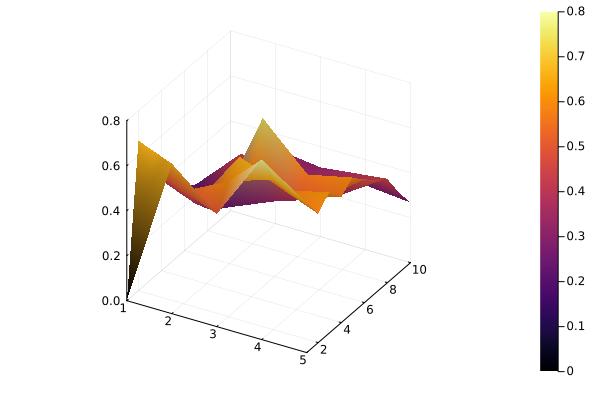

In [10]:
using Plots 

x = x 
y = 1:n
z = percentages

surface(z)